# Influence functions for data mislabeling


In this notebook, we will take a closer look at the theory of influence functions with the help of a synthetic dataset. Data mislabeling occurs whenever some examples from a usually big dataset are wrongly-labeled. In real-life this happens fairly often, e.g. as a consequence of human error, or noise in the data. 

Let's consider a classification problem with the following notation:

$$
\begin{align*}
x_i &\in \mathbb{R}^d \\
y_i &\in \{0, 1\} \\
\forall i &\in [ N ]
\end{align*}
$$

In other words, we have a dataset containing $N$ samples, each with label 1 or 0. As typical example you can think of y indicating whether a patient has a disease based on some feature representation $x$. 

Let's now introduce a toy model that will help us delve into the theory and practical utility of influence functions. We will assume that $y$ is a Bernoulli binary random variable while the input $x$ is d-dimensional Gaussian distribution which depends on the label $y$. More precisely:

$$
y_i \sim \text{Ber}\left (0.5 \right) \\
x_i \sim \mathcal{N}\left ((1 - y_i) \mu_1 + y_i \mu_2, \sigma^2 I \right),
$$

with fixed means and diagonal covariance. Implementing the sampling scheme in python is straightforward and can be achieved by first sampling $y$ and afterward $x$.

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pydvl.influence.general import compute_influences
from pydvl.influence.model_wrappers import TorchBinaryLogisticRegression
from pydvl.utils.dataset import (
    synthetic_classification_dataset,
    decision_boundary_fixed_variance_2d,
)
from pydvl.utils.plotting import plot_dataset, plot_influences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim import AdamW, lr_scheduler

In [3]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10

## Constants

In [4]:
random_state = 24
is_CI = os.environ.get("CI")

In [5]:
num_samples = 10000
num_features = 2
sigma = 0.2
means = np.asarray([[0.0, 0.0], [1.0, 1.0]])

num_classes = len(means)

In [6]:
random.seed(random_state)
np.random.seed(random_state)

## Dataset

The following code snippet generates the aforementioned dataset.

In [7]:
train_ds, val_ds, test_ds = synthetic_classification_dataset(
    means, sigma, num_samples, train_size=0.7, test_size=0.2
)
# In CI we only use a subset of the training set
if is_CI:
    train_data[0] = train_data[0][:10]
    train_data[1] = train_data[1][:10]

Given the simplicity of the dataset, we can calculate exactly the optimal decision boundary(that which maximizes our accuracy). The following code maps a continuous line of z values to a 2-dimensional vector in feature space (More details are in the appendix to this notebook.)

In [8]:
decision_boundary_fn = decision_boundary_fixed_variance_2d(means[0], means[1])
decision_boundary = decision_boundary_fn(np.linspace(-1.5, 1.5, 100))

## Plotting the dataset
Let's plot the dataset is plotted with their respective labels and the optimal decision line

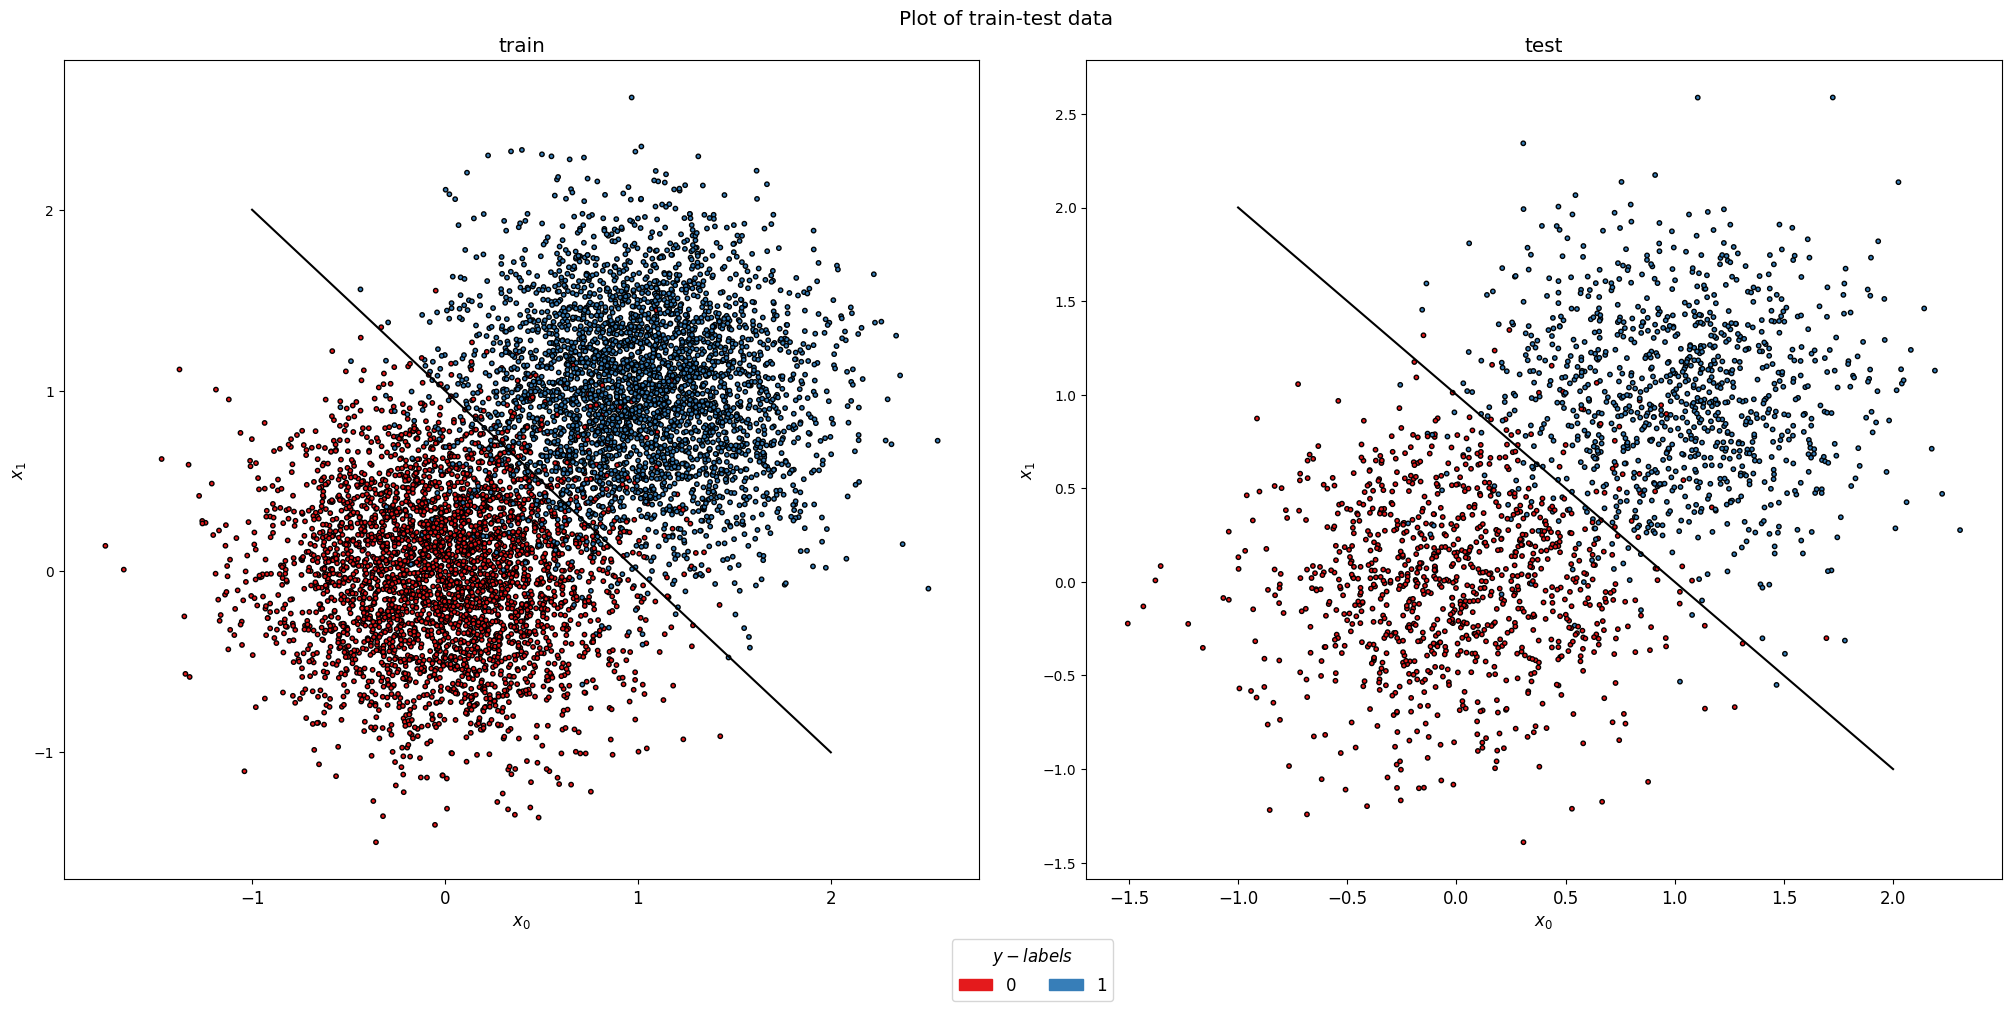

In [9]:
datasets = {
    "train": train_ds,
    "test": test_ds,
}
x_min = np.asarray([-2, -2])
x_max = np.asarray([3, 3])
plot_dataset(
    train_ds,
    test_ds,
    xlabel="$x_0$",
    ylabel="$x_1$",
    legend_title="$y - labels$",
    line=decision_boundary,
    s=10,
    suptitle="Plot of train-test data",
)

Note that there are samples which go across the optimal decision boundary and will be wrongly labelled. The optimal decision boundary can not discriminate these as the mislabelling is a consequence of the presence of random noise.

## Training the model

We will now train a logistic regression model on the train data. This can be done with the following

In [10]:
model = TorchBinaryLogisticRegression(num_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50
lr = 0.05
weight_decay = 0.05
batch_size = 128

optimizer = AdamW(params=model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train_loss, val_loss = model.fit(
    x_train=train_ds[0],
    y_train=train_ds[1].astype(float),
    x_val=val_ds[0],
    y_val=val_ds[1].astype(float),
    loss=F.binary_cross_entropy,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    batch_size=batch_size,
)

/home/anesbenmerzoug/workdir/repositories/transferlab/pyDVL/.tox/notebooks/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


And let's check that the model is not overfitting

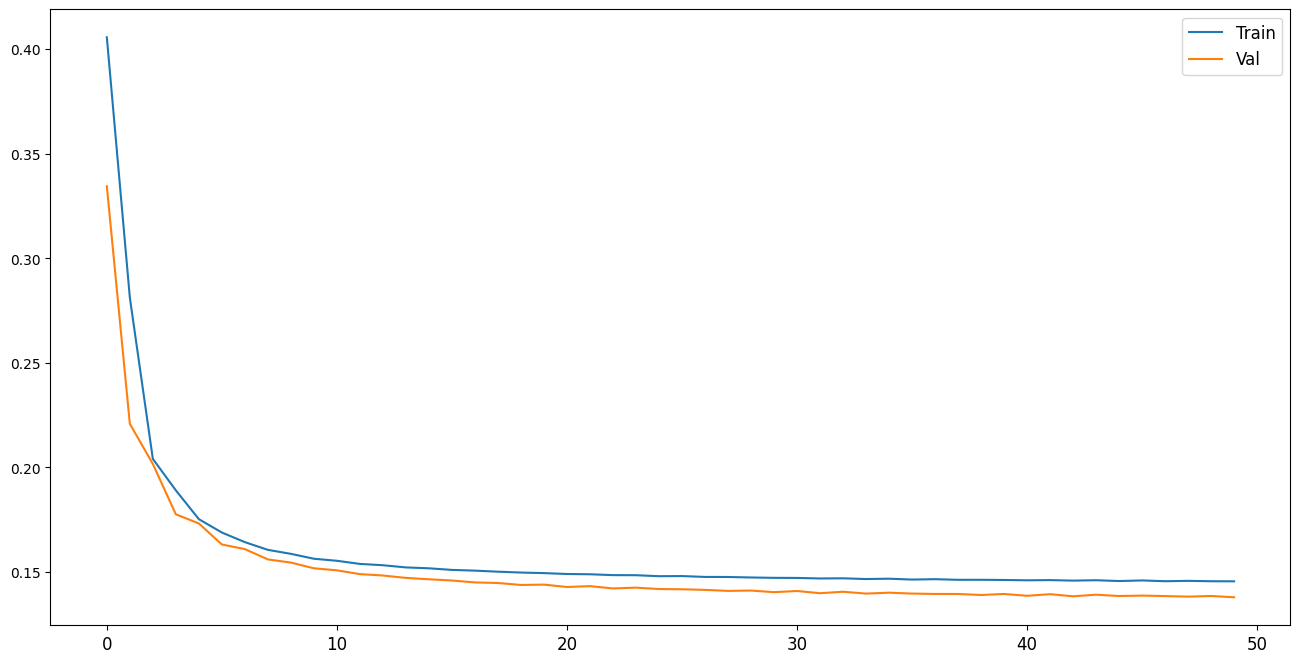

In [11]:
_, ax = plt.subplots()
ax.plot(train_loss, label="Train")
ax.plot(val_loss, label="Val")
ax.legend()
plt.show()

A look at the confusion matrix also shows good results

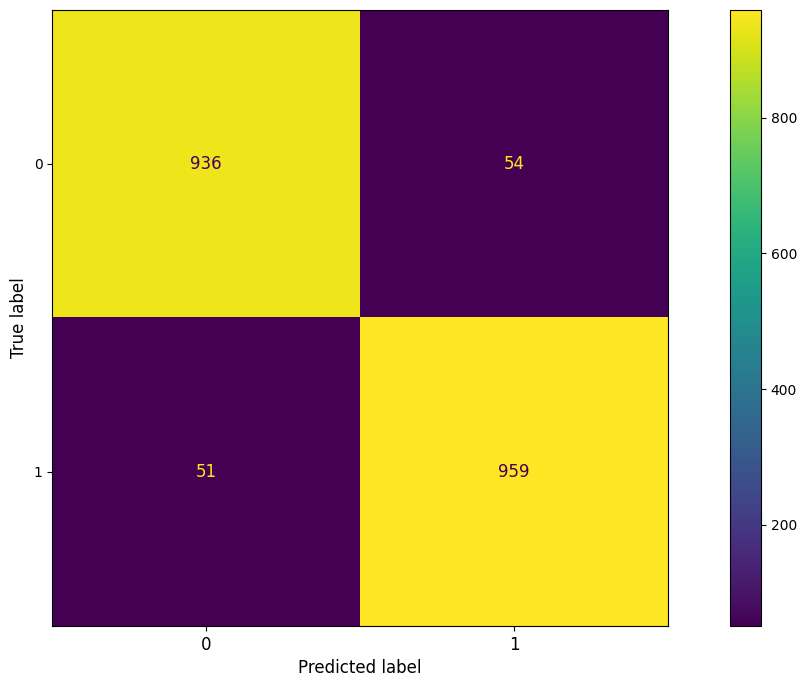

In [12]:
pred_probabilities = model(test_ds[0]).detach()
pred_y_test = [1 if prob > 0.5 else 0 for prob in pred_probabilities]

cm = confusion_matrix(test_ds[1], pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

## Calculating influences

It is important that the model converges to a point near the optimum, since the influence values assume that we are at a minimum (or close) in the loss landscape. The function

$$I(x_1, y_1, x_2, y_2) \colon \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$$

measures the influence of the data point $x_1$ onto $x_2$ conditioned on the training targets $y_1$ and $y_2$ trough some model parameters $\theta$. If the loss function L is differentiable, we can take $I$ to be

$$
I(x_1, x_2) = \nabla_\theta\; L(x_1, y_1) ^\mathsf{T} \; H_\theta^{-1} \; \nabla_\theta \; L(x_2, y_2)
$$
See ["Understanding Black-box Predictions via Influence Functions"](https://arxiv.org/pdf/1703.04730.pdf) for a detailed derivation of this formula

Let's take a subset of the training data points, which we will calculate the influence values of. 

In [13]:
x = train_ds[0][:100]
y = train_ds[1][:100]

In pyDVL, the influence of the training points on the test points can be calculated with the following

In [14]:
influence_values = compute_influences(
    model=model,
    loss=F.binary_cross_entropy,
    x=x,
    y=y.astype(float),
    x_test=test_ds[0],
    y_test=test_ds[1].astype(float),
    influence_type="up",
    inversion_method="direct",  # use 'cg' for big models
)

The above explicitly constructs the Hessian. This can often be computationally expensive and conjugate gradient approximate calculation should be used for bigger models. 

With the influence type 'up', train influences have shape [NxM] where N is the number of test samples and M is the number of training samples. They therefore associate to each training sample its influence on each test sample. 
Influence type 'perturbation', instead, return an array of shape  [NxMxF], where F is the number of features in input, ie. the length of x. 

In our case, in order to have a value of the total average influence of a point we can just average across training samples.

In [15]:
mean_train_influences = np.mean(influence_values, axis=0)

Let's plot the results (adjust colorbar_limits for better color gradient)

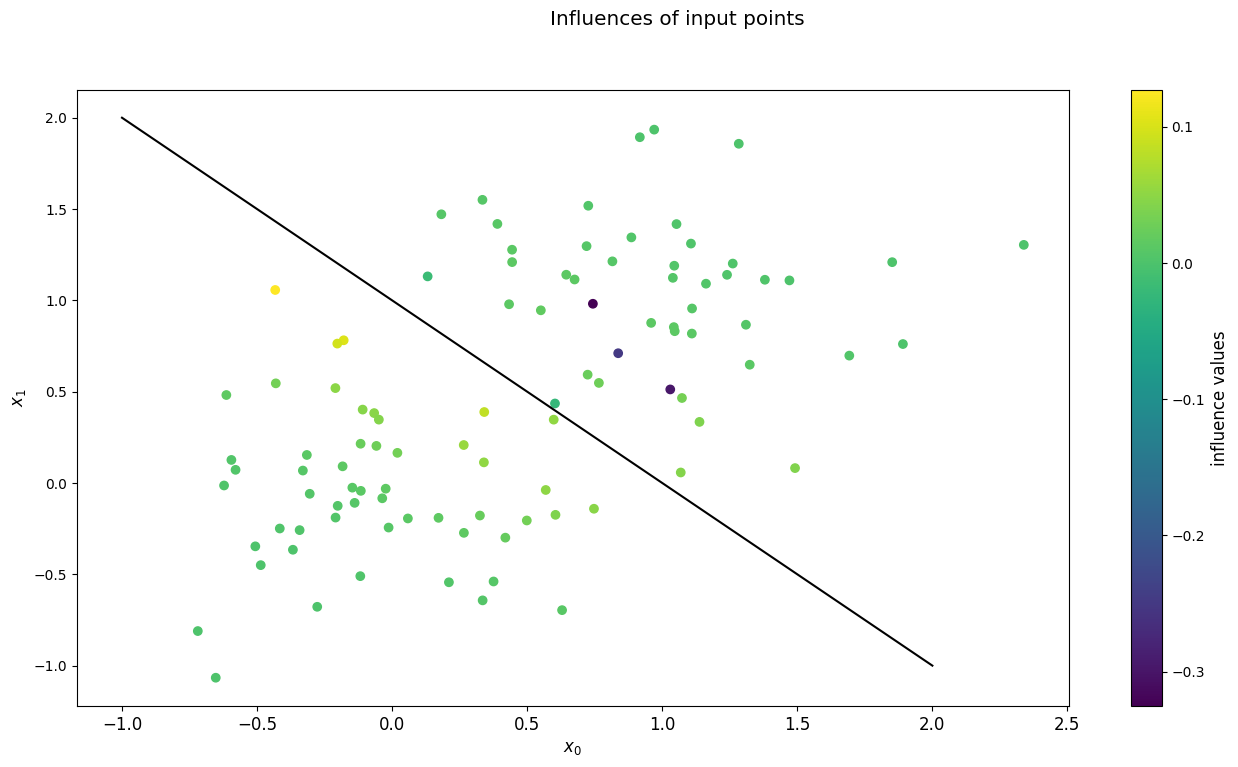

In [16]:
plot_influences(
    x,
    mean_train_influences,
    line=decision_boundary,
    xlabel="$x_0$",
    ylabel="$x_1$",
    suptitle="Influences of input points",
    legend_title="influence values",
    # colorbar_limits=(-0.3,),
);

We can see that, as we approach the separation line, the influences tend to move away from zero, i.e. the points become more decisive for model training, some in a positive way, some negative.

As a further test, let's introduce some labelling errors into $y$ and see how the distribution of the influences changes. Let's flip the first 10 labels and calculate influences

In [17]:
y_corrupted = np.copy(y)
y_corrupted[:10] = [1 - yi for yi in y[:10]]

influence_values = compute_influences(
    model=model,
    loss=F.binary_cross_entropy,
    x=x,
    y=y_corrupted.astype(float),
    x_test=test_ds[0],
    y_test=test_ds[1].astype(float),
    influence_type="up",
    inversion_method="direct",
)

mean_train_influences = np.mean(influence_values, axis=0)

In [18]:
print("Average mislabelled data influence:", np.mean(mean_train_influences[:10]))
print("Average correct data influence:", np.mean(mean_train_influences[10:]))

Average mislabelled data influence: -0.7100426885862152
Average correct data influence: 0.007572591027364254


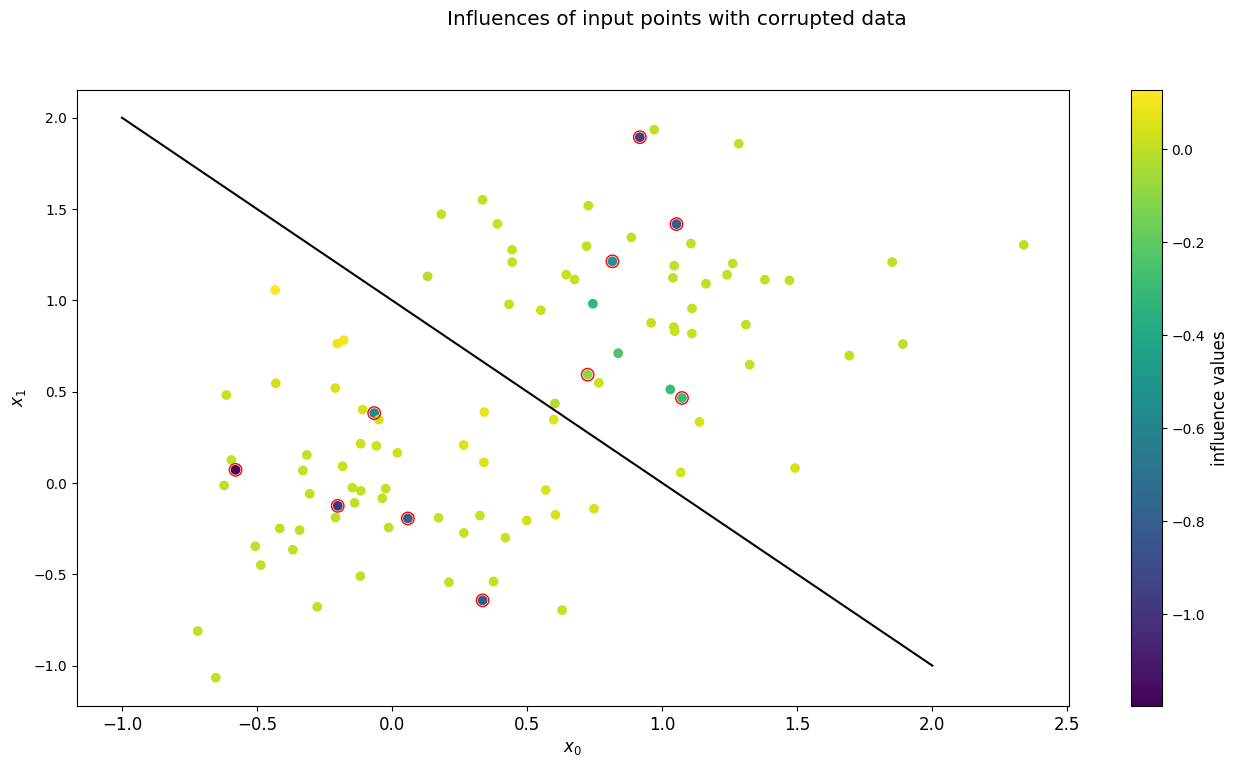

In [19]:
plot_influences(
    x,
    mean_train_influences,
    corrupted_indices=np.array(range(10)),
    line=decision_boundary,
    xlabel="$x_0$",
    ylabel="$x_1$",
    suptitle="Influences of input points with corrupted data",
    legend_title="influence values",
    # colorbar_limits=(-0.3,),
);

Red circles indicate the points which have been corrupted. We can see that the mislabelled data have a more negative average influence on the model, especially those that are farther away from the decision boundary.

## Inversion through conjugate gradient

The "direct" method that we have used above involves the inversion of the Hessian matrix of the model. If a model has $n$ training points and $\theta  \in \mathbb{R}^p$ parameters, this requires $O(n \ p^2 + p^3)$ operations, which for larger models, like neural networks, becomes quickly unfeasible. Conjugate gradient avoids the explicit computation of the Hessian via a technique called implicit Hessian-vector products (HVPs), which typically takes $O(n \ p)$ operations.

In the next cell we will use conjugate gradient to compute the influence factors. Since logistic regression is a very simple model, "cg" actually slows computation with respect to the direct method, which in this case is a much better choice. Nevertheless, we are able to verify that the influences calculated with "cg" are the same (to a minor error) as those calculated directly.

In [20]:
influence_values = compute_influences(
    model=model,
    loss=F.binary_cross_entropy,
    x=x,
    y=y_corrupted.astype(float),
    x_test=test_ds[0],
    y_test=test_ds[1].astype(float),
    influence_type="up",
    inversion_method="cg",
    inversion_method_kwargs={"max_iterations": 10, "max_step_size": 1},
)
mean_train_influences = np.mean(influence_values, axis=0)

print("Average mislabelled data influence:", np.mean(mean_train_influences[:10]))
print("Average correct data influence:", np.mean(mean_train_influences[10:]))

Average mislabelled data influence: -0.7100421121793015
Average correct data influence: 0.007572591538602831


Averages are very similar to the ones calculated through direct method. Same is true for the plot

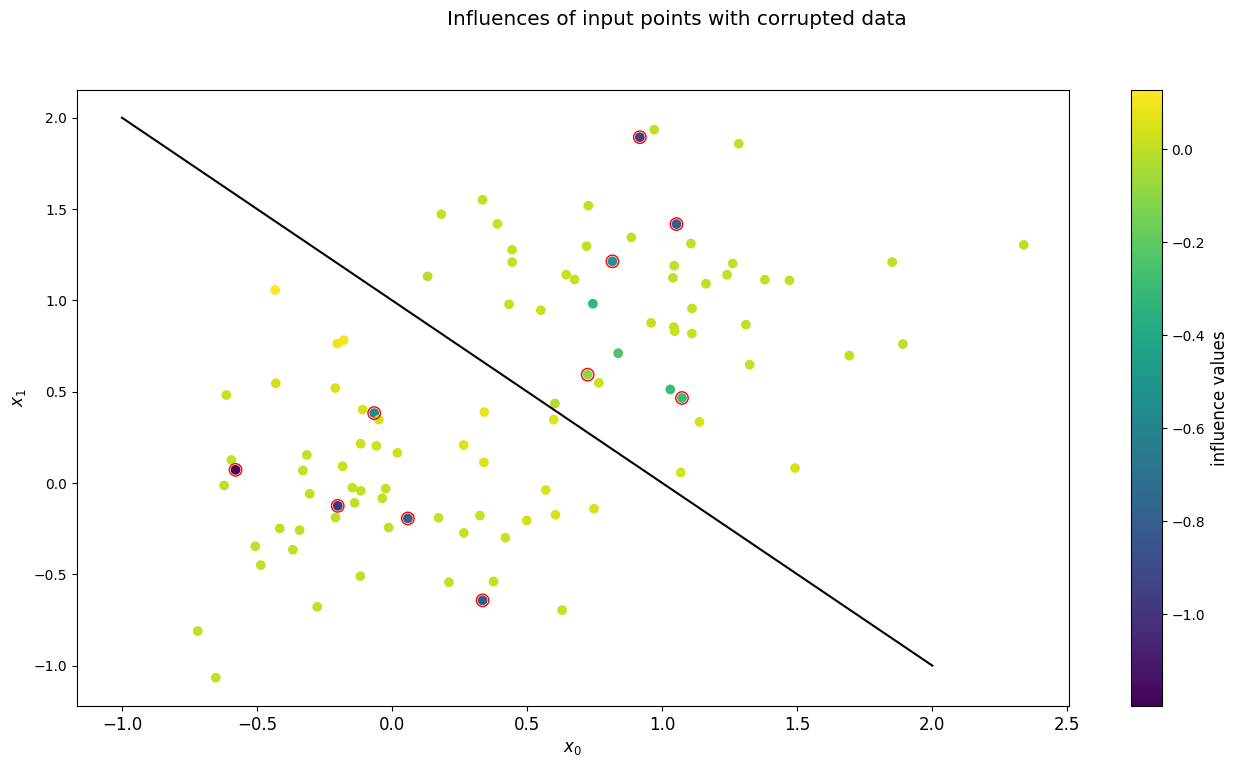

In [21]:
plot_influences(
    x,
    mean_train_influences,
    corrupted_indices=np.array(range(10)),
    line=decision_boundary,
    xlabel="$x_0$",
    ylabel="$x_1$",
    suptitle="Influences of input points with corrupted data",
    legend_title="influence values",
    # colorbar_limits=(-0.1, 0.1),
);

## Appendix: Calculating the decision boundary

For obtaining the optimal discriminator one has to solve the equation

$$p(x|y=0)=p(x|y=1)$$

and determine the solution set $X$. Let's take the following probabilities

$$
\begin{align*}
p(x|y=0)&=\mathcal{N}\left (\mu_1, \sigma^2 I \right) \\
p(x|y=1)&=\mathcal{N}\left (\mu_2, \sigma^2 I \right)
\end{align*}
$$

For a single fixed diagonal variance parameterized by $\sigma$, the optimal discriminator lays at points which are equidistant from the means of the two distributions, i.e.

$$
\begin{align*}
\| x - \mu_1 \|^2 &= \| x - \mu_2 \|^2 \\
\| \mu_1 \|^2 -2 x^\mathsf{T} \mu_1 &= \| \mu_2 \|^2 -2 x^\mathsf{T} \mu_2 \\
\implies 0 &= 2 (\mu_2 - \mu_1)^\mathsf{T} x + \| \mu_1 \|^2 - \| \mu_2 \|^2 \\
0 &= \mu_1^\mathsf{T}x - \mu_2^\mathsf{T}x - \frac{1}{2} \mu_1^\mathsf{T} \mu_1 + \frac{1}{2} \mu_2^\mathsf{T} \mu_2
\end{align*}
$$

This is just the implicit description of the line. Solving for the explicit form can be achieved by enforcing a functional form $f(z) = x = a z + b$ with $z \in \mathbb{R}$ onto $x$. After the term is inserted in the previous equation

$$
0 = (\mu_2 - \mu_1)^\mathsf{T} (az + b) + \frac{1}{2} \| \mu_1 \|^2 - \| \mu_2 \|^2
$$

We can write $a$ since, by symmetry, it is expected to be explicitly orthogonal to $\mu_2 - \mu_1$. Then, solving for $b$, the solution can be found to be

$$
f(z) = \underbrace{\begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} (\mu_2 - \mu_1)}_a z + \underbrace{\frac{\mu_1 + \mu_2}{2}}_b
$$